In [216]:
import sys
import os
import snntorch as snn
from snntorch import utils, spikegen
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import snntorch.spikeplot as splt
from IPython.display import HTML

In [217]:
batch_size = 128
data_path = 'E:/Code/SCNN-and-Resnet50-on-Medical-MNIST-classification/data/raw'
num_classes = 6
dtype = torch.float  

In [218]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.ImageFolder(data_path, transform=transform)
print(len(mnist_train))

58954


 Apply `data_subset` to reduce the dataset by the factor defined in `subset`. *E.g., for `subset=10`, a training set of 58,954 will be reduced to 5896.* (Can not use data_subset here because ImageFolder.data does not exists)

In [219]:
subset = 10
indices = list(range(0, len(mnist_train), subset))
mnist_train_subset = Subset(mnist_train, indices)
print(f"The size of mnist_train_subset is {len(mnist_train_subset)}")

The size of mnist_train_subset is 5896


In [220]:
train_loader = DataLoader(mnist_train_subset, batch_size=batch_size, shuffle=True)

1. Pass the training sample each time step to create a time-varying alike dataset.
2. Convert input into spike train of length `num_steps`.
    2a- rate_code == Bernouli_trail (where each input feauter used as probabality of spike)



Rate coding of MNIST

In [221]:
# Temporal Dynamics
num_steps = 100

# create vector filled with 0.5
# this means each time step there is a 50% chance to spike
raw_vector = torch.ones(num_steps)*0.5 # [.5, .5, .5, .5, .5, .5, .5, .5, .5, .5] 

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
# print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 48.00% of the time.


In [222]:
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data_no_gain = spikegen.rate(data_it, num_steps=num_steps,)
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)
print(spike_data.size())

torch.Size([100, 128, 1, 64, 64])


In [223]:
spike_data_sample = spike_data[:, 0, 0]
spike_data_sample2 = spike_data_no_gain[:, 0, 0]
print(spike_data_sample.size())
print(spike_data_sample2.size())

torch.Size([100, 64, 64])
torch.Size([100, 64, 64])


The corresponding target is: 4


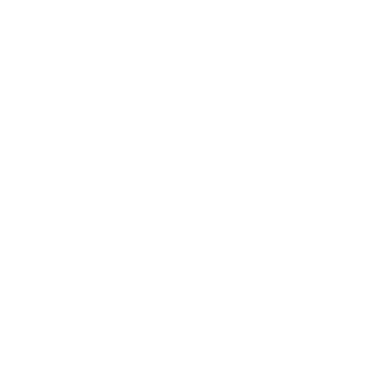

In [224]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

# HTML(anim.to_html5_video())
anim.save(f"./notebooks/spike_gifs/spike_medical_mnist_reduced_gain_{targets_it[0]}.gif")
print(f"The corresponding target is: {targets_it[0]}")

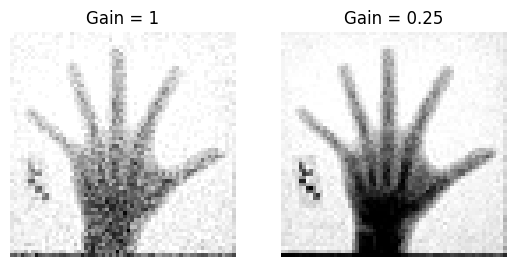

In [225]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((64,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((64,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

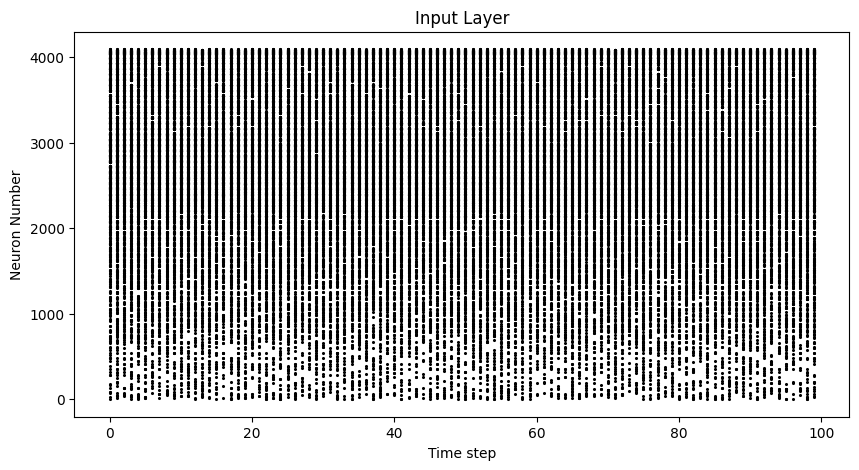

In [226]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

Picking one Neuron to show its spiking times

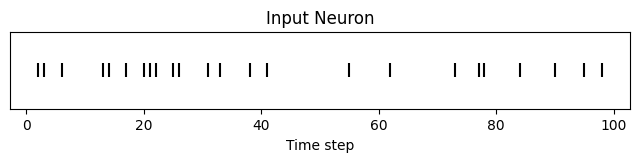

In [ ]:
idx = 4000  

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")

plt.yticks([])
plt.show()

Latency Coding of MNIST ( firing time )

In [266]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time 

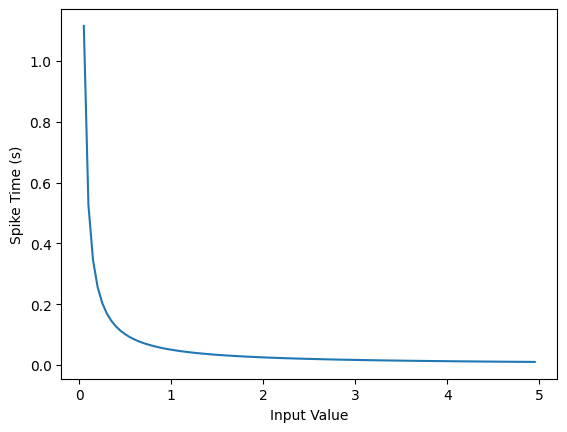

In [267]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

To span the full range of the num_steps, `linear=True` or increaseing `tau` to slow down the time constant, and `clip=true` make the "useless" blackground pixels be removed

In [276]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, clip=True, normalize=True, linear=True)

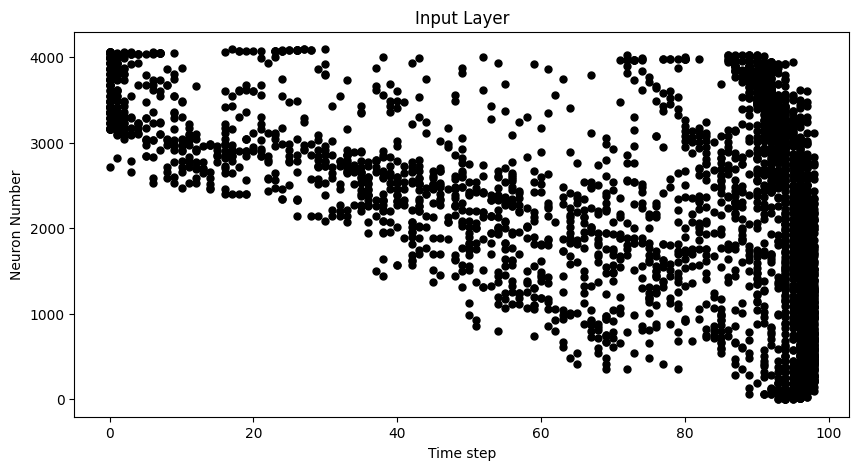

In [277]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [278]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 64, 64])


The corresponding target is: 4


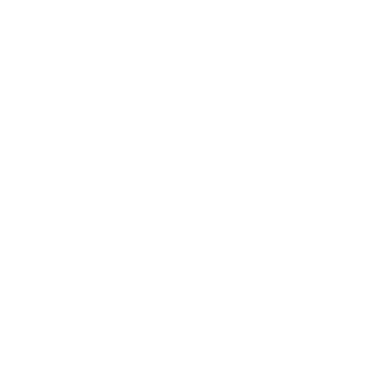

In [279]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

# HTML(anim.to_html5_video())
anim.save(f"./notebooks/spike_gifs/spike_medical_mnist_latency_{targets_it[0]}.gif")
print(f"The corresponding target is: {targets_it[0]}")

Delta Modulation

It takes the difference between each subsequent feature across all time steps. By default, if the difference is both positive and greater than the threshold, a spike is generated. Where compress time-series data by only generating spikes for sufficiently large changes/events

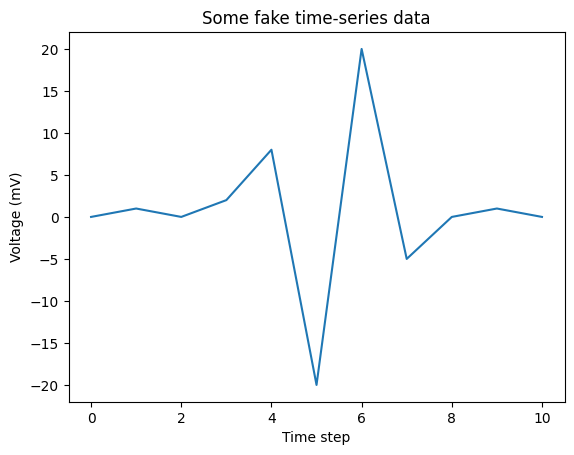

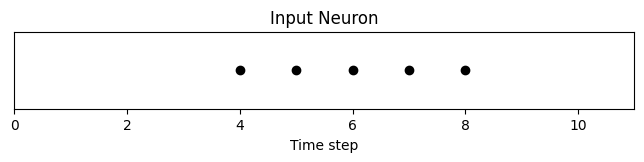

spike_data: tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


In [303]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

print("spike_data:",spike_data)